# Introducción

El objetivo de este proyecto es generar imágenes realistas de rostros de gatos utilizando una red neuronal autoencoder variacional (VAE). Este tipo de red es capaz de crear nuevas representaciones visuales que imitan la apariencia de los rostros de gatos, basándose en la estructura y los patrones presentes en los datos de entrenamiento.

## Configuración del repositorio

### Para ejecutar en Colab

Si se ejecuta este notebook en Google Colab, se debe subir el repositorio a Google Drive y ejecutar las siguientes celdas:

In [1]:
import os
try:
    from google.colab import drive
    using_colab = True
except ModuleNotFoundError:
    using_colab = False

Además, se debe dar permisos para acceder a la cuenta de Google Drive y configurar la constante `DATASET_PATH` con la dirección al dataset:

In [2]:
if using_colab:
    drive.mount('/content/drive')
    REPO_PATH = "/content/drive/MyDrive/Repositories/Generación de rostros de gatos/" # Configurar según path en Google Drive
    DATASET_PATH = "cats"
    os.sys.path.append(os.path.join(REPO_PATH, "dev"))

else:
    REPO_PATH = ".."
    DATASET_PATH = os.path.join(REPO_PATH , "data", "cats")

### Descarga del Dataset

El dataset se encuentra en el archivo comprimido `data/cats.zip`. Para ejecutar el notebook, es necesario descomprimir este archivo. Si estamos en Colab, se puede ejecutar la siguiente celda:

In [5]:
!unzip "/content/drive/MyDrive/Repositories/Generación de rostros de gatos/data/cats.zip"  -d "/content"

  inflating: /content/cats/5499.jpg  
  inflating: /content/cats/55.jpg    
  inflating: /content/cats/550.jpg 
  ...


## Librerías a utilizar

In [6]:
import os
from typing import Optional, Callable

import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader

from src import (
    VAE,
    BetaLoss,
    train,
)

# Dataset y Dataloaders

Tal como se definió en `data/data_exploration.ipynb`, se utiliza el dataset [Cats Faces 64x64 (for generative models)](https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models/data). A continuación, se crea la clase `CatsDataset`:

In [7]:
class CatsDataset(Dataset):
    def __init__(
            self,
            dataset_path: str,
            transform: Optional[Callable] = None,
        ):
        images_names = os.listdir(dataset_path)

        self.X = []
        print(f"[-] Cargando imágenes de {dataset_path}:")
        for image_name in tqdm(images_names):
            img_path = os.path.join(dataset_path, image_name)

            image = Image.open(img_path)
            if transform:
                image = transform(image)
            self.X.append(image)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], 0

Se implementa una transformación que convierte los arreglos a tensores, y además se aplica un resize para asegurarnos de que todas las imágenes tengan las dimensiones $64 \times 64$:

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

Por último, se instancia el dataset y se crean el data loader:

In [9]:
cat_dataset = CatsDataset(DATASET_PATH, transform=transform)

[-] Cargando imágenes de ..\data\cats:


100%|██████████| 15747/15747 [04:20<00:00, 60.52it/s]


# Variational Autoencoder (VAE)

En esta sección se describe el diseño, implementación y entrenamiento de un Variational Autoencoder (VAE). Este modelo es un tipo de red neuronal generativa que combina un codificador (encoder) y un decodificador (decoder) para aprender representaciones latentes de los datos de entrada. El enfoque principal es explorar diferentes arquitecturas del VAE, ajustando componentes clave como las dimensiones latentes, las funciones de pérdida y la configuración de los hiperparámetros.


## Paquete para la implementación del VAE

Para facilitar el entrenamiento de los modelos, el paquete `src/` contiene tres funcionalidades clave:

### 1. VAE (Variational Autoencoder)

El modelo VAE implementa un codificador (encoder) y un decodificador (decoder) para comprimir y reconstruir datos. Este modelo utiliza el truco de reparametrización para aprender una distribución latente que captura la estructura subyacente de los datos.

#### Principales parámetros del constructor
- **image_h** (int): Altura de la imagen de entrada.
- **image_w** (int): Ancho de la imagen de entrada.
- **latent_dims** (int): Dimensionalidad del espacio latente.
- **hidden_channels** (list[int]): Lista con los canales ocultos de cada capa convolucional.
- **kernel_size** (int): Tamaño del kernel para las convoluciones.
- **stride** (int): Stride (desplazamiento) utilizado en las convoluciones.
- **padding** (int): Padding aplicado en las convoluciones.
- **activation** (`nn.Module`): Función de activación utilizada en las capas.

#### Métodos principales
- **encode(X)**: Codifica una entrada `X` y devuelve la representación latente, junto con la media y la varianza logarítmica.
- **decode(z)**: Decodifica una representación latente `z` para reconstruir la entrada.
- **forward(X)**: Encadena las fases de codificación y decodificación en un único paso.
- **init_weights()**: Inicializa los pesos del modelo utilizando el método de inicialización de Kaiming.

### 2. BetaLoss

Esta clase implementa una pérdida personalizada basada en la combinación de la pérdida de reconstrucción y la pérdida latente ponderada por un factor $\beta$.

#### Principales parámetros del constructor
- **beta** (float): Factor de ponderación para la pérdida latente.

#### Método principal:
- **forward(x, x_hat, mean, log_var)**
  - **x**: Entrada original.
  - **x_hat**: Salida reconstruida por el VAE.
  - **mean**: Media de la distribución latente.
  - **log_var**: Varianza logarítmica de la distribución latente.
  - **Retorna**: La suma ponderada de la pérdida de reconstrucción y la pérdida latente.

### 3. Función de entrenamiento

La función `train()` entrena el modelo por un número especificado de épocas, guarda checkpoints periódicamente y calcula las métricas de validación.

#### Principales parámetros
- **model** (`nn.Module`): Modelo a entrenar.
- **train_loader** (`DataLoader`): DataLoader para los datos de entrenamiento.
- **val_loader** (`DataLoader` o `None`): DataLoader para los datos de validación (opcional).
- **epochs** (int): Número total de épocas para entrenar.
- **epochs_per_checkpoint** (int): Intervalo de épocas para guardar checkpoints.
- **device** (str): Dispositivo donde se ejecutará el entrenamiento (e.g., `cpu` o `cuda`).
- **model_dir** (str): Directorio donde se guardarán los pesos y el historial.
- **optimizer** (`torch.optim.Optimizer`): Optimizador utilizado para actualizar los pesos.
- **loss_function** (`nn.Module`): Función de pérdida utilizada en el entrenamiento.

#### Flujo principal
1. **Preparación del modelo**:
   - Verifica si existen pesos previamente entrenados en el directorio especificado.
   - Carga los pesos más recientes si están disponibles.
2. **Entrenamiento**:
   - Por cada época, entrena el modelo utilizando el `train_loader` y calcula el promedio de la pérdida.
   - Si se especifica un `val_loader`, calcula la pérdida promedio en el conjunto de validación.
3. **Checkpointing**:
   - Guarda los pesos del modelo y actualiza las métricas en un archivo `.csv` después de cada época.

Esta estructura modular permite entrenar un modelo VAE de manera eficiente y realizar un seguimiento detallado del proceso.

# Entrenamiento del modelo

In [10]:
if using_colab:
    MODELS = os.path.join(REPO_PATH, "dev", "models")
else:
    MODELS = "models"


def get_model_path(model_name):
    return os.path.join(MODELS, model_name)

In [11]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [12]:
cat_loader = DataLoader(dataset=cat_dataset, batch_size=128, shuffle=True)

print(f"El conjunto de datos de gatos tiene {len(cat_dataset)} imágenes")

El conjunto de datos de gatos tiene 15747 imágenes


## VAE V1

In [13]:
vae_v1_config = {
    "image_h": 64,
    "image_w": 64,
    "latent_dims": 500,
    "hidden_channels": [3, 32, 64, 128, 256],
    "kernel_size": 4,
    "stride": 2,
    "padding": 1,
    "activation": nn.LeakyReLU(),
}

In [ ]:
vae_v1 = VAE(**vae_v1_config).to(device)

In [ ]:
optimizer = torch.optim.Adam(vae_v1.parameters(), lr=1e-3)

history = train(
    model=vae_v1,
    train_loader=cat_loader,
    val_loader=None,
    epochs=901,
    epochs_per_checkpoint=100,
    optimizer=optimizer,
    device=device,
    model_dir=get_model_path("vae_v1"),
    loss_function=BetaLoss(beta=1.),
)


[-] Resuming training from epoch: 900
[-] Starting epoch: 901
[-] Training: 
100%|██████████| 124/124 [00:39<00:00,  3.13it/s]
Train Loss: 875912.738892



<Axes: title={'center': 'Pérdida en función del número de épocas'}, xlabel='epoch'>

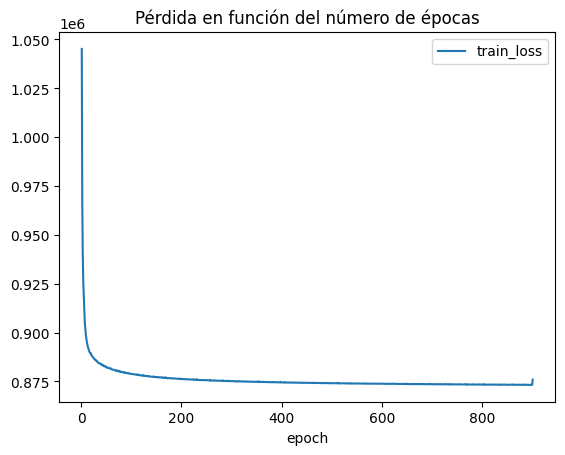

In [ ]:
history_df = pd.read_csv(os.path.join(get_model_path("vae_v1"), "history.csv"))
history_df.plot(x="epoch", y=["train_loss"], title="Pérdida en función del número de épocas")

## VAE V2

In [14]:
vae_v2_config = {
    "image_h": 64,
    "image_w": 64,
    "latent_dims": 500,
    "hidden_channels": [3, 32, 64, 128, 256],
    "kernel_size": 4,
    "stride": 2,
    "padding": 1,
    "activation": nn.LeakyReLU(),
}

In [ ]:
vae_v2 = VAE(**vae_v2_config).to(device)

In [ ]:
optimizer = torch.optim.Adam(vae_v2.parameters(), lr=1e-3)

history = train(
    model=vae_v2,
    train_loader=cat_loader,
    val_loader=None,
    epochs=901,
    epochs_per_checkpoint=100,
    optimizer=optimizer,
    device=device,
    model_dir=get_model_path("vae_v2"),
    loss_function=BetaLoss(beta=2.),
)

<Axes: title={'center': 'Pérdida en función del número de épocas'}, xlabel='epoch'>

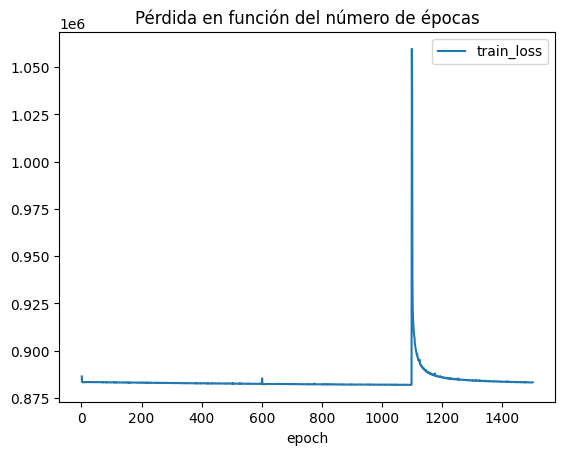

In [ ]:
history_df = pd.read_csv(os.path.join(get_model_path("vae_v2"), "history.csv"))
history_df.plot(x="epoch", y=["train_loss"], title="Pérdida en función del número de épocas")

Entre las epochs 1000 y 1200, la pérdida tiene un gran pico, lo cual distorsiona completamente el gráfico. Para evitar esto, analizaremos el gráfico hasta la epoch 1050:

<Axes: title={'center': 'Pérdida en función del número de épocas'}, xlabel='epoch'>

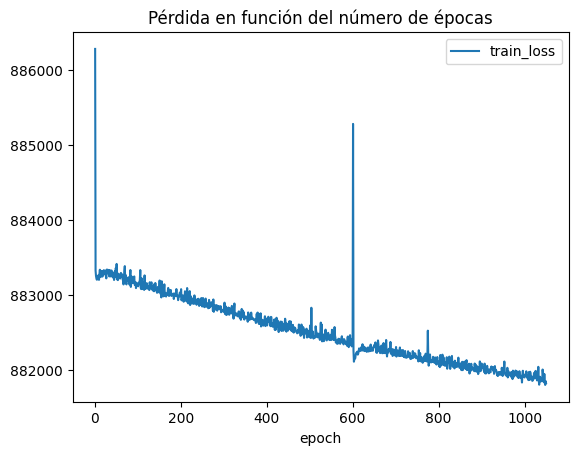

In [ ]:
history_df.iloc[0:1050].plot(x="epoch", y=["train_loss"], title="Pérdida en función del número de épocas")

## VAE V3

In [15]:
vae_v3_config = {
    "image_h": 64,
    "image_w": 64,
    "latent_dims": 100,
    "hidden_channels": [3, 32, 64],
    "kernel_size": 4,
    "stride": 2,
    "padding": 1,
    "activation": nn.ReLU(),
}

In [ ]:
vae_v3 = VAE(**vae_v3_config).to(device)

In [ ]:
optimizer = torch.optim.Adam(vae_v3.parameters(), lr=1e-3)

history = train(
    model=vae_v3,
    train_loader=cat_loader,
    val_loader=None,
    epochs=1201,
    epochs_per_checkpoint=100,
    optimizer=optimizer,
    device=device,
    model_dir=get_model_path("vae_v3"),
    loss_function=BetaLoss(beta=1.),
)

[-] Starting epoch: 1200
[-] Training: 
100%|██████████| 124/124 [00:01<00:00, 71.41it/s]
Train Loss: 1023439.194333


[-] Starting epoch: 1201
[-] Training: 
100%|██████████| 124/124 [00:01<00:00, 70.47it/s]
Train Loss: 1023423.960485


<Axes: title={'center': 'Pérdida en función del número de épocas'}, xlabel='epoch'>

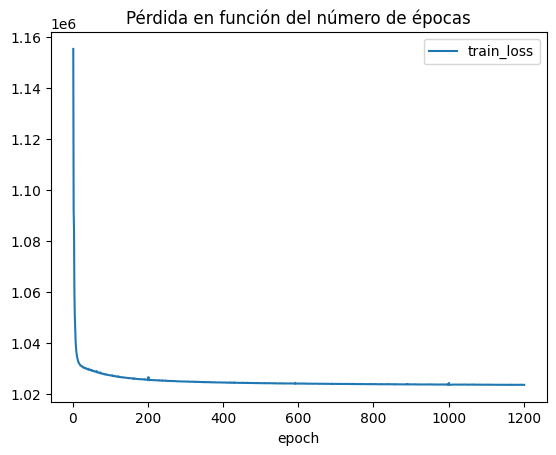

In [ ]:
history_df = pd.read_csv(os.path.join(get_model_path("vae_v3"), "history.csv"))
history_df.plot(x="epoch", y=["train_loss"], title="Pérdida en función del número de épocas")

## VAE V4

In [16]:
vae_v4_config = {
    "image_h": 64,
    "image_w": 64,
    "latent_dims": 500,
    "hidden_channels": [3, 32, 64, 128, 256],
    "kernel_size": 4,
    "stride": 2,
    "padding": 1,
    "activation": nn.LeakyReLU(),
}

In [ ]:
vae_v4 = VAE(**vae_v4_config).to(device)

In [17]:
optimizer = torch.optim.Adam(vae_v4.parameters(), lr=1e-3)

history = train(
    model=vae_v4,
    train_loader=cat_loader,
    val_loader=None,
    epochs=1201,
    epochs_per_checkpoint=100,
    optimizer=optimizer,
    device=device,
    model_dir=get_model_path("vae_v4"),
    loss_function=BetaLoss(beta=0.5),
)

[-] Starting epoch: 249
[-] Training: 
100%|██████████| 124/124 [00:03<00:00, 38.89it/s]
Train Loss: 867864.381586


[-] Starting epoch: 250
[-] Training: 
100%|██████████| 124/124 [00:03<00:00, 39.32it/s]

...



<Axes: title={'center': 'Pérdida en función del número de épocas'}, xlabel='epoch'>

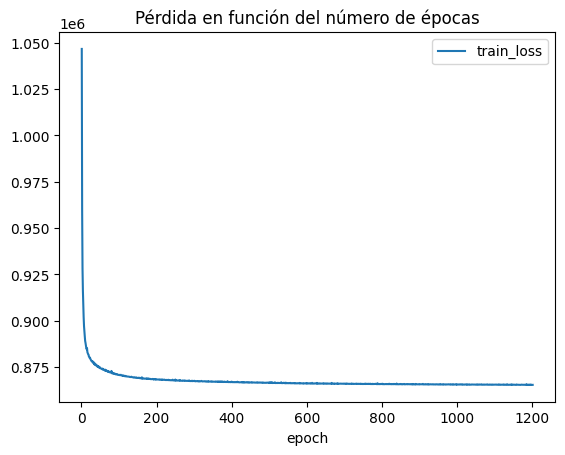

In [ ]:
history_df = pd.read_csv(os.path.join(get_model_path("vae_v4"), "history.csv"))
history_df.plot(x="epoch", y=["train_loss"], title="Pérdida en función del número de épocas")

## VAE v5

In [18]:
vae_v5_config = {
    "image_h": 64,
    "image_w": 64,
    "latent_dims": 500,
    "hidden_channels": [3, 32, 64, 128, 256],
    "kernel_size": 4,
    "stride": 2,
    "padding": 1,
    "activation": nn.LeakyReLU(),
}

In [ ]:
vae_v5 = VAE(**vae_v5_config).to(device)

In [20]:
optimizer = torch.optim.Adam(vae_v5.parameters(), lr=1e-3)

history = train(
    model=vae_v5,
    train_loader=cat_loader,
    val_loader=None,
    epochs=1201,
    epochs_per_checkpoint=100,
    optimizer=optimizer,
    device=device,
    model_dir=get_model_path("vae_v5"),
    loss_function=BetaLoss(beta=0.05),
)

[-] Starting epoch: 249
[-] Training: 
100%|██████████| 124/124 [00:03<00:00, 39.33it/s]
Train Loss: 852422.080145


[-] Starting epoch: 250
[-] Training: 
100%|██████████| 124/124 [00:03<00:00, 39.25it/s]

...
      


<Axes: title={'center': 'Pérdida en función del número de épocas'}, xlabel='epoch'>

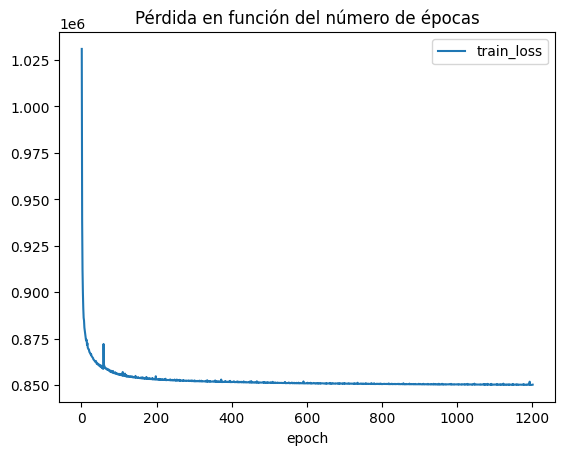

In [19]:
history_df = pd.read_csv(os.path.join(get_model_path("vae_v5"), "history.csv"))
history_df.plot(x="epoch", y=["train_loss"], title="Pérdida en función del número de épocas")

## VAE v6

In [21]:
vae_v6_config = {
    "image_h": 64,
    "image_w": 64,
    "latent_dims": 500,
    "hidden_channels": [3, 32, 64, 128, 256],
    "kernel_size": 4,
    "stride": 2,
    "padding": 1,
    "activation": nn.LeakyReLU(),
}

In [19]:
vae_v6 = VAE(**vae_v6_config).to(device)

In [20]:
optimizer = torch.optim.Adam(vae_v6.parameters(), lr=1e-3)

history = train(
    model=vae_v6,
    train_loader=cat_loader,
    val_loader=None,
    epochs=1201,
    epochs_per_checkpoint=100,
    optimizer=optimizer,
    device=device,
    model_dir=get_model_path("vae_v6"),
    loss_function=BetaLoss(beta=0.005),
)

[-] Resuming training from epoch: 1200


/content/drive/MyDrive/Repositories/Generación de rostros de gatos/dev/src/train.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(latest_weights, map_locatio

[-] Starting epoch: 1201
[-] Training: 

100%|██████████| 124/124 [00:04<00:00, 27.18it/s]


Train Loss: 850145.982643




<Axes: title={'center': 'Pérdida en función del número de épocas'}, xlabel='epoch'>

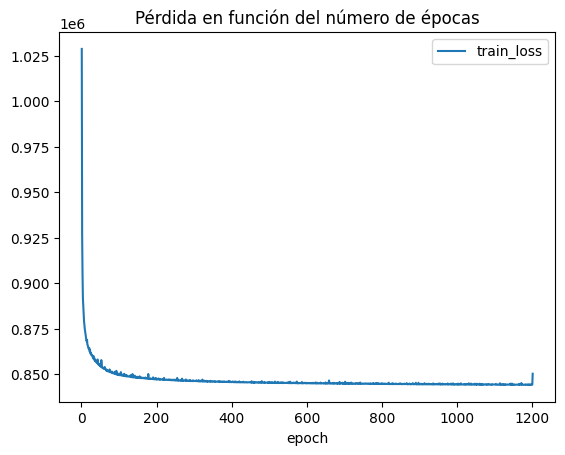

In [24]:
history_df = pd.read_csv(os.path.join(get_model_path("vae_v6"), "history.csv"))
history_df.plot(x="epoch", y=["train_loss"], title="Pérdida en función del número de épocas")

# Selección de modelo

## Obtención de los mejores modelos

In [26]:
best_vae_v1 = VAE(**vae_v1_config).to("cpu")
best_vae_v1.load_state_dict(
    torch.load(
        os.path.join(get_model_path("vae_v1"), "best-train.pt"),
        map_location=torch.device('cpu'),
        ),
)

C:\Users\tinte\AppData\Local\Temp\ipykernel_4468\3759377218.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [27]:
best_vae_v2 = VAE(**vae_v2_config).to("cpu")
best_vae_v2.load_state_dict(
    torch.load(
        os.path.join(get_model_path("vae_v2"), "best-train.pt"),
        map_location=torch.device('cpu'),
        ),
)

C:\Users\tinte\AppData\Local\Temp\ipykernel_4468\2087511824.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [28]:
best_vae_v3 = VAE(**vae_v3_config).to("cpu")
best_vae_v3.load_state_dict(
    torch.load(
        os.path.join(get_model_path("vae_v3"), "best-train.pt"),
        map_location=torch.device('cpu'),
        ),
)

C:\Users\tinte\AppData\Local\Temp\ipykernel_4468\2390414249.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [29]:
best_vae_v4 = VAE(**vae_v4_config).to("cpu")
best_vae_v4.load_state_dict(
    torch.load(
        os.path.join(get_model_path("vae_v4"), "best-train.pt"),
        map_location=torch.device('cpu'),
        ),
)

C:\Users\tinte\AppData\Local\Temp\ipykernel_4468\3500075950.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [30]:
best_vae_v5 = VAE(**vae_v5_config).to("cpu")
best_vae_v5.load_state_dict(
    torch.load(
        os.path.join(get_model_path("vae_v5"), "best-train.pt"),
        map_location=torch.device('cpu'),
        ),
)

C:\Users\tinte\AppData\Local\Temp\ipykernel_4468\2971563987.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [31]:
best_vae_v6 = VAE(**vae_v6_config).to("cpu")
best_vae_v6.load_state_dict(
    torch.load(
        os.path.join(get_model_path("vae_v6"), "best-train.pt"),
        map_location=torch.device('cpu'),
        ),
)

C:\Users\tinte\AppData\Local\Temp\ipykernel_4468\531098562.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

## Análisis de las reconstrucciones

In [32]:
def plot_decoded_samples(
    models: list[VAE],
    dataset: Dataset,
    sample_indexes: list[int],
    model_names: list[str] = None,
    device: str = "cpu"
):
    """
    Muestra imágenes reales y sus reconstrucciones generadas por varios modelos VAE.

    Args:
        models (List[VAE]): Lista de modelos VAE utilizados para reconstruir las imágenes.
        dataset (Dataset): Dataset que contiene las imágenes originales.
        sample_indexes (List[int]): Índices de las imágenes en el dataset para reconstruir.
        model_names (List[str], optional): Nombres de los modelos, con igual longitud que `models`.
                                           Si no se proporciona, se generarán nombres genéricos.
        device (str, optional): Dispositivo para realizar las operaciones (e.g., 'cpu' o 'cuda').
                                Por defecto, 'cpu'.

    Raises:
        ValueError: Si la longitud de `models` y `model_names` no coincide.
    """
    # Generar nombres genéricos para los modelos si no se proporcionan
    if model_names is None:
        model_names = [f"Model {i}" for i in range(1, len(models) + 1)]

    # Validar que la cantidad de modelos coincida con la cantidad de nombres
    assert len(models) == len(model_names), "La cantidad de modelos y nombres de modelos debe coincidir."

    # Iterar sobre cada índice de muestra proporcionado
    for idx in sample_indexes:
        # Obtener la imagen y etiqueta correspondiente
        img, label = dataset[idx]
        img = img.unsqueeze(0).to(device)  # Añadir dimensión batch y enviar al dispositivo

        # Configurar la figura
        num_models = len(models)
        figsize = (len(models) + 2, len(models) + 2)
        fig, axs = plt.subplots(1, num_models + 1, figsize=figsize)

        # Mostrar la imagen original
        img_array = img.squeeze().permute(1, 2, 0).cpu().numpy()
        axs[0].imshow(img_array)
        axs[0].set_title("Original")
        axs[0].axis("off")

        # Procesar y mostrar la reconstrucción de cada modelo
        for i, (model, model_name) in enumerate(zip(models, model_names), start=1):
            model = model.to(device)  # Enviar el modelo al dispositivo
            model.eval()  # Configurar el modelo en modo evaluación
            with torch.no_grad():
                # Reconstruir la imagen con el modelo
                reconstructed_img, _, _ = model(img)
                reconstructed_img = reconstructed_img.squeeze().permute(1, 2, 0).cpu().numpy()

            # Mostrar la imagen reconstruida
            axs[i].imshow(reconstructed_img)
            axs[i].set_title(model_name)
            axs[i].axis("off")

        # Ajustar diseño y mostrar la figura
        plt.tight_layout()
        plt.show()

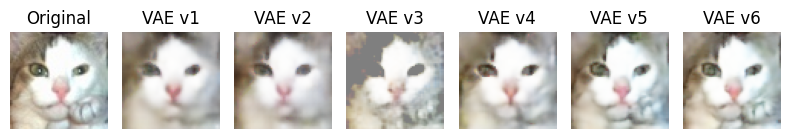

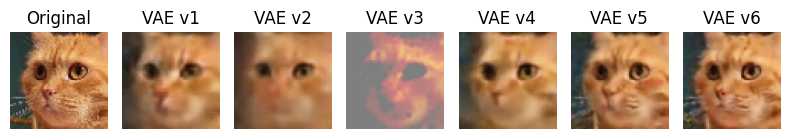

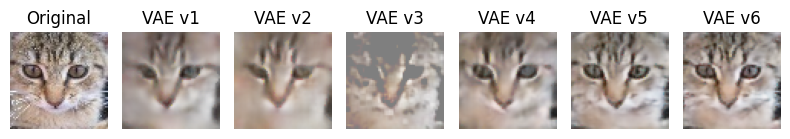

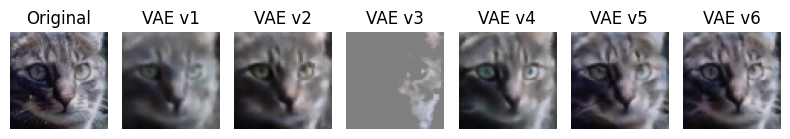

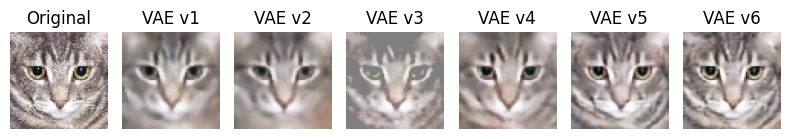

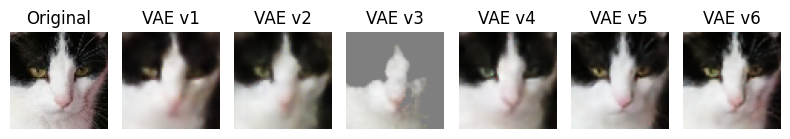

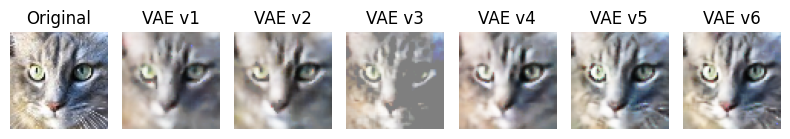

In [40]:
plot_decoded_samples(
    models=[
        best_vae_v1, best_vae_v2, best_vae_v3, 
        best_vae_v4, best_vae_v5, best_vae_v6
    ],
    model_names=[
        "VAE v1", "VAE v2", "VAE v3", 
        "VAE v4", "VAE v5", "VAE v6"
    ],
    dataset=cat_dataset,
    sample_indexes=[3, 24, 36, 45, 50, 51, 9999],
)

## Análisis de las interpolaciones

In [42]:
def plot_linear_interpolation(
        models: list[VAE],
        model_names: list[str],
        dataset: Dataset,
        index_1: int,
        index_2: int,
        device: str,
        steps: int = 10
    ):
    """
    Muestra interpolaciones lineales entre dos imágenes en el espacio latente, generadas por uno o más modelos.

    Args:
        models (list[VAE]): Lista de modelos VAE para generar las interpolaciones.
        model_names (list[str]): Lista con los nombres de los modelos.
        dataset (Dataset): Dataset que contiene las imágenes.
        index_1 (int): Índice de la primera imagen en el dataset.
        index_2 (int): Índice de la segunda imagen en el dataset.
        device (str): Dispositivo en el cual realizar las operaciones (e.g., 'cpu' o 'cuda').
        steps (int, optional): Número de pasos de interpolación entre las imágenes. Por defecto, 10.
    """
    assert len(models) == len(model_names), "La longitud de `models` y `model_names` debe ser igual."

    num_models = len(models)

    # Preparar las imágenes iniciales
    img_1, _ = dataset[index_1]
    img_2, _ = dataset[index_2]
    img_1 = img_1.to(device).unsqueeze(0)
    img_2 = img_2.to(device).unsqueeze(0)

    # Figura
    figsize = (3 * (steps + 3), 3 * num_models)  # +3 para la columna adicional de nombres
    fig, axs = plt.subplots(num_models, steps + 3, figsize=figsize, squeeze=False)

    for model_idx, model in enumerate(models):
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            # Codificar imágenes en el espacio latente
            latent_1, _, _ = model.encode(img_1)
            latent_2, _, _ = model.encode(img_2)

            # Generar interpolaciones en el espacio latente
            v1 = latent_1.squeeze().to("cpu").numpy()
            v2 = latent_2.squeeze().to("cpu").numpy()
            interps = np.linspace(v1, v2, steps + 2)
            interps = torch.tensor(interps, device=device).float()

            # Decodificar las interpolaciones
            decoded_interps = model.decode(interps)

        # Mostrar el nombre del modelo en la primera columna
        axs[model_idx, 0].text(0.5, 0.5, model_names[model_idx], fontsize=20, ha='center', va='center', rotation=90)
        axs[model_idx, 0].axis("off")

        # Mostrar las imágenes interpoladas
        axs[model_idx, 1].imshow(img_1.squeeze().permute(1, 2, 0).cpu().numpy())
        axs[model_idx, 1].set_title("Real 1")
        axs[model_idx, 1].axis("off")

        axs[model_idx, -1].imshow(img_2.squeeze().permute(1, 2, 0).cpu().numpy())
        axs[model_idx, -1].set_title("Real 2")
        axs[model_idx, -1].axis("off")

        for step_idx, interp in enumerate(decoded_interps[1:-1]):
            img = interp.squeeze().permute(1, 2, 0).cpu().numpy()
            axs[model_idx, step_idx + 2].imshow(img)
            axs[model_idx, step_idx + 2].set_title(f"Interp {step_idx + 1}")
            axs[model_idx, step_idx + 2].axis("off")

    plt.tight_layout()
    plt.show()


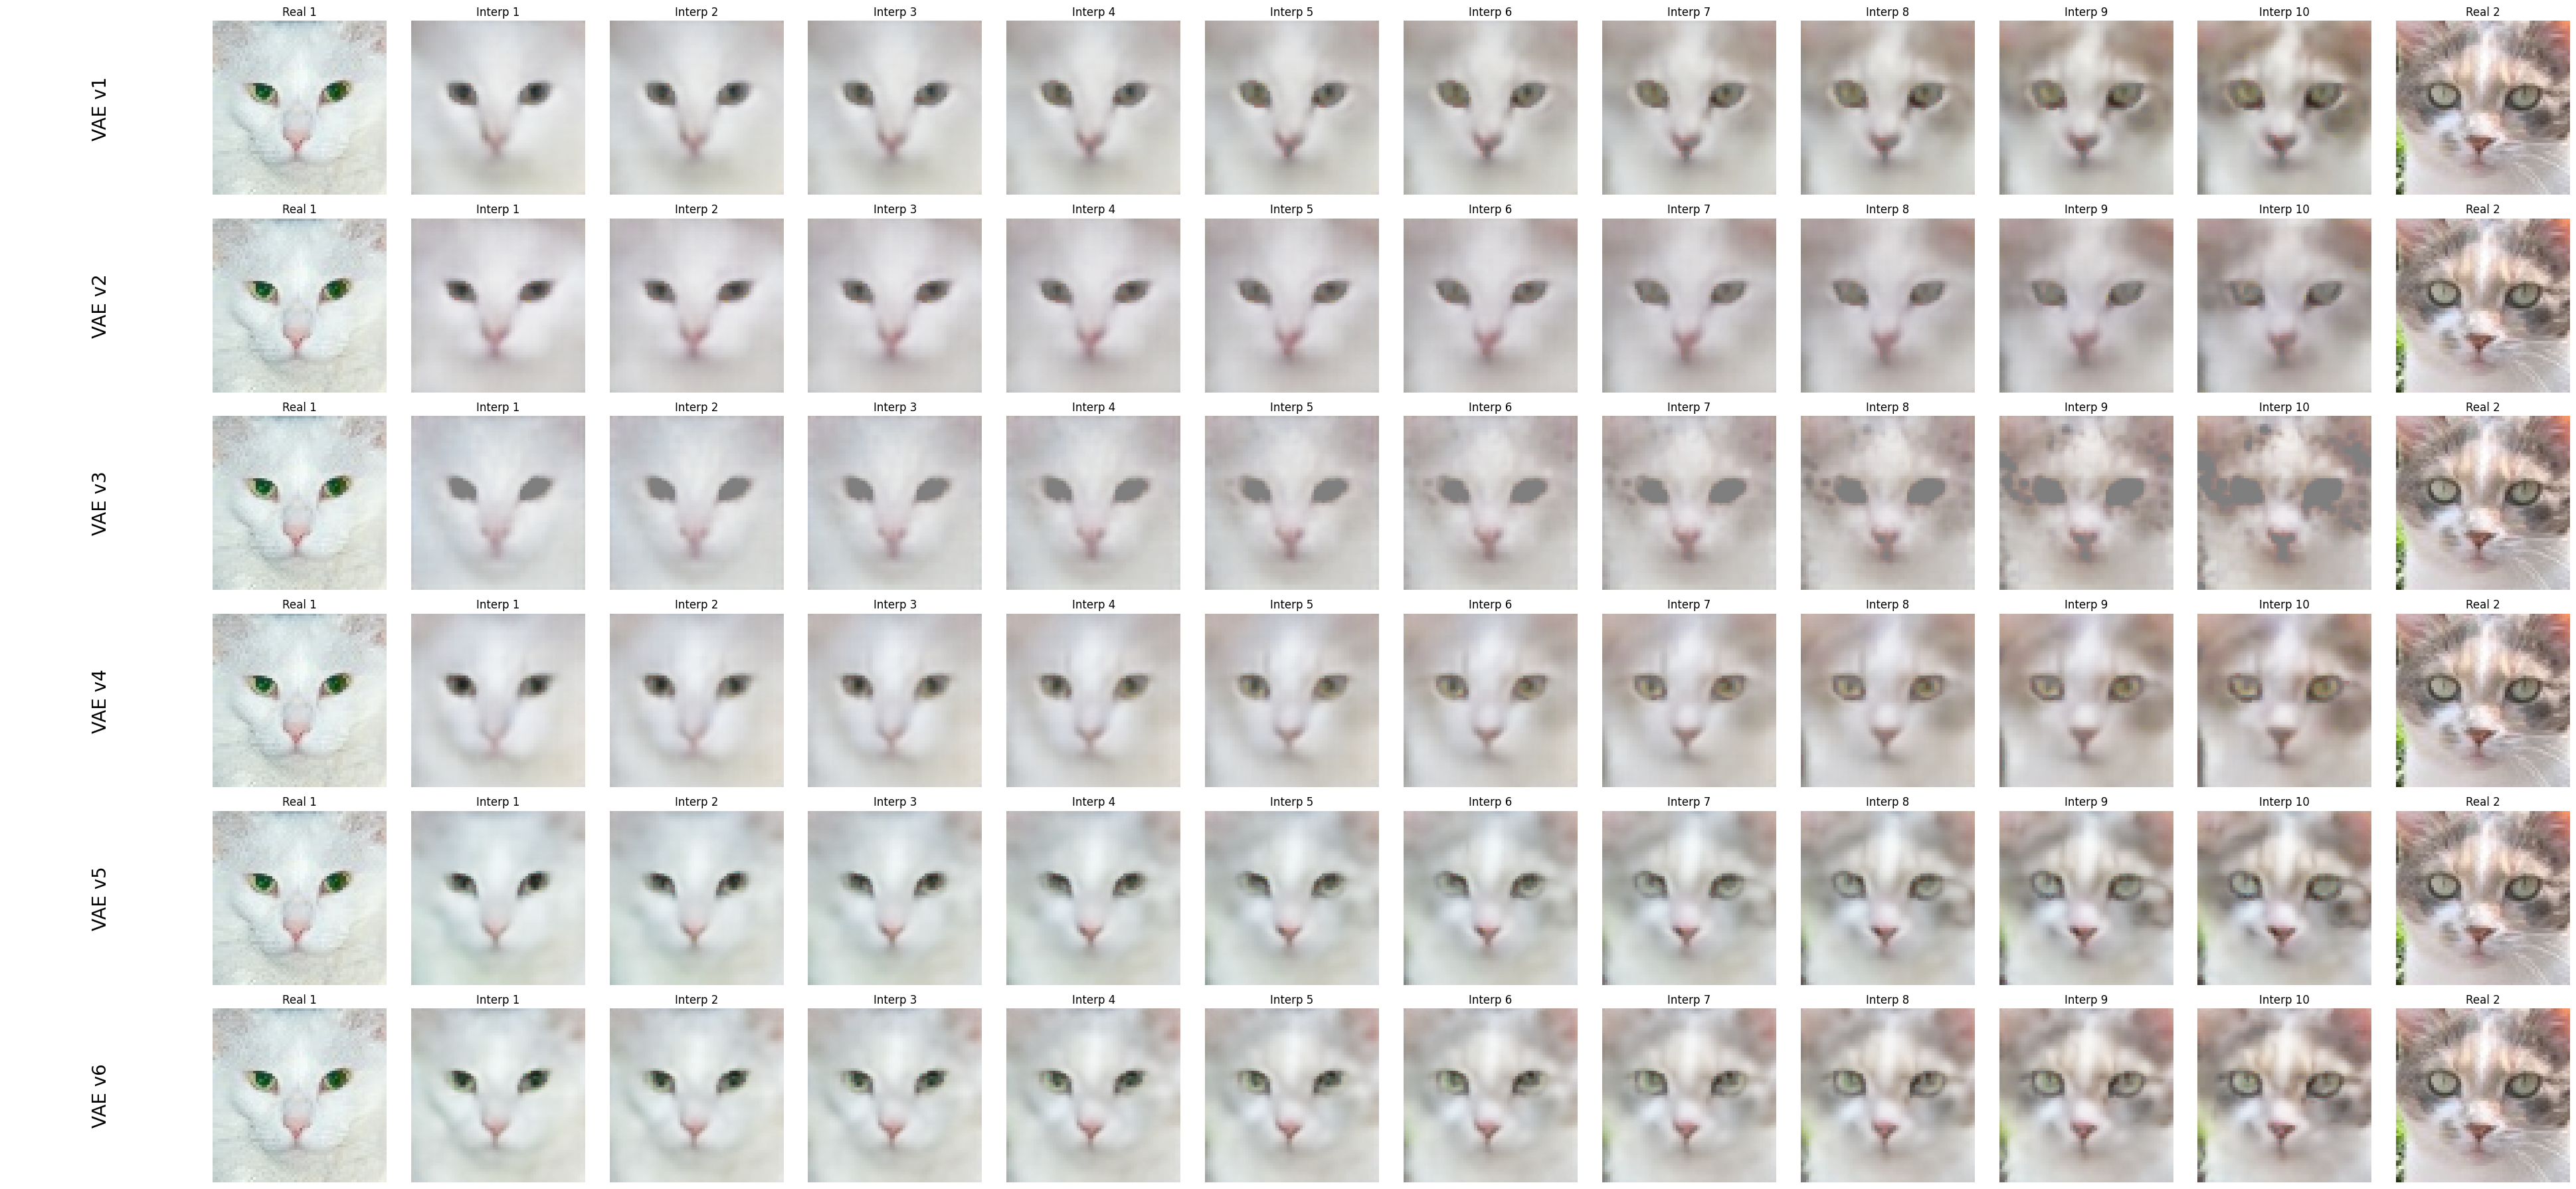

In [80]:
plot_linear_interpolation(
    index_1=485, index_2=9923,
    models=[
        best_vae_v1, best_vae_v2, best_vae_v3, 
        best_vae_v4, best_vae_v5, best_vae_v6
    ],
    model_names=[
        "VAE v1", "VAE v2", "VAE v3", 
        "VAE v4", "VAE v5", "VAE v6"
    ],
    device="cpu",
    dataset=cat_dataset,
)

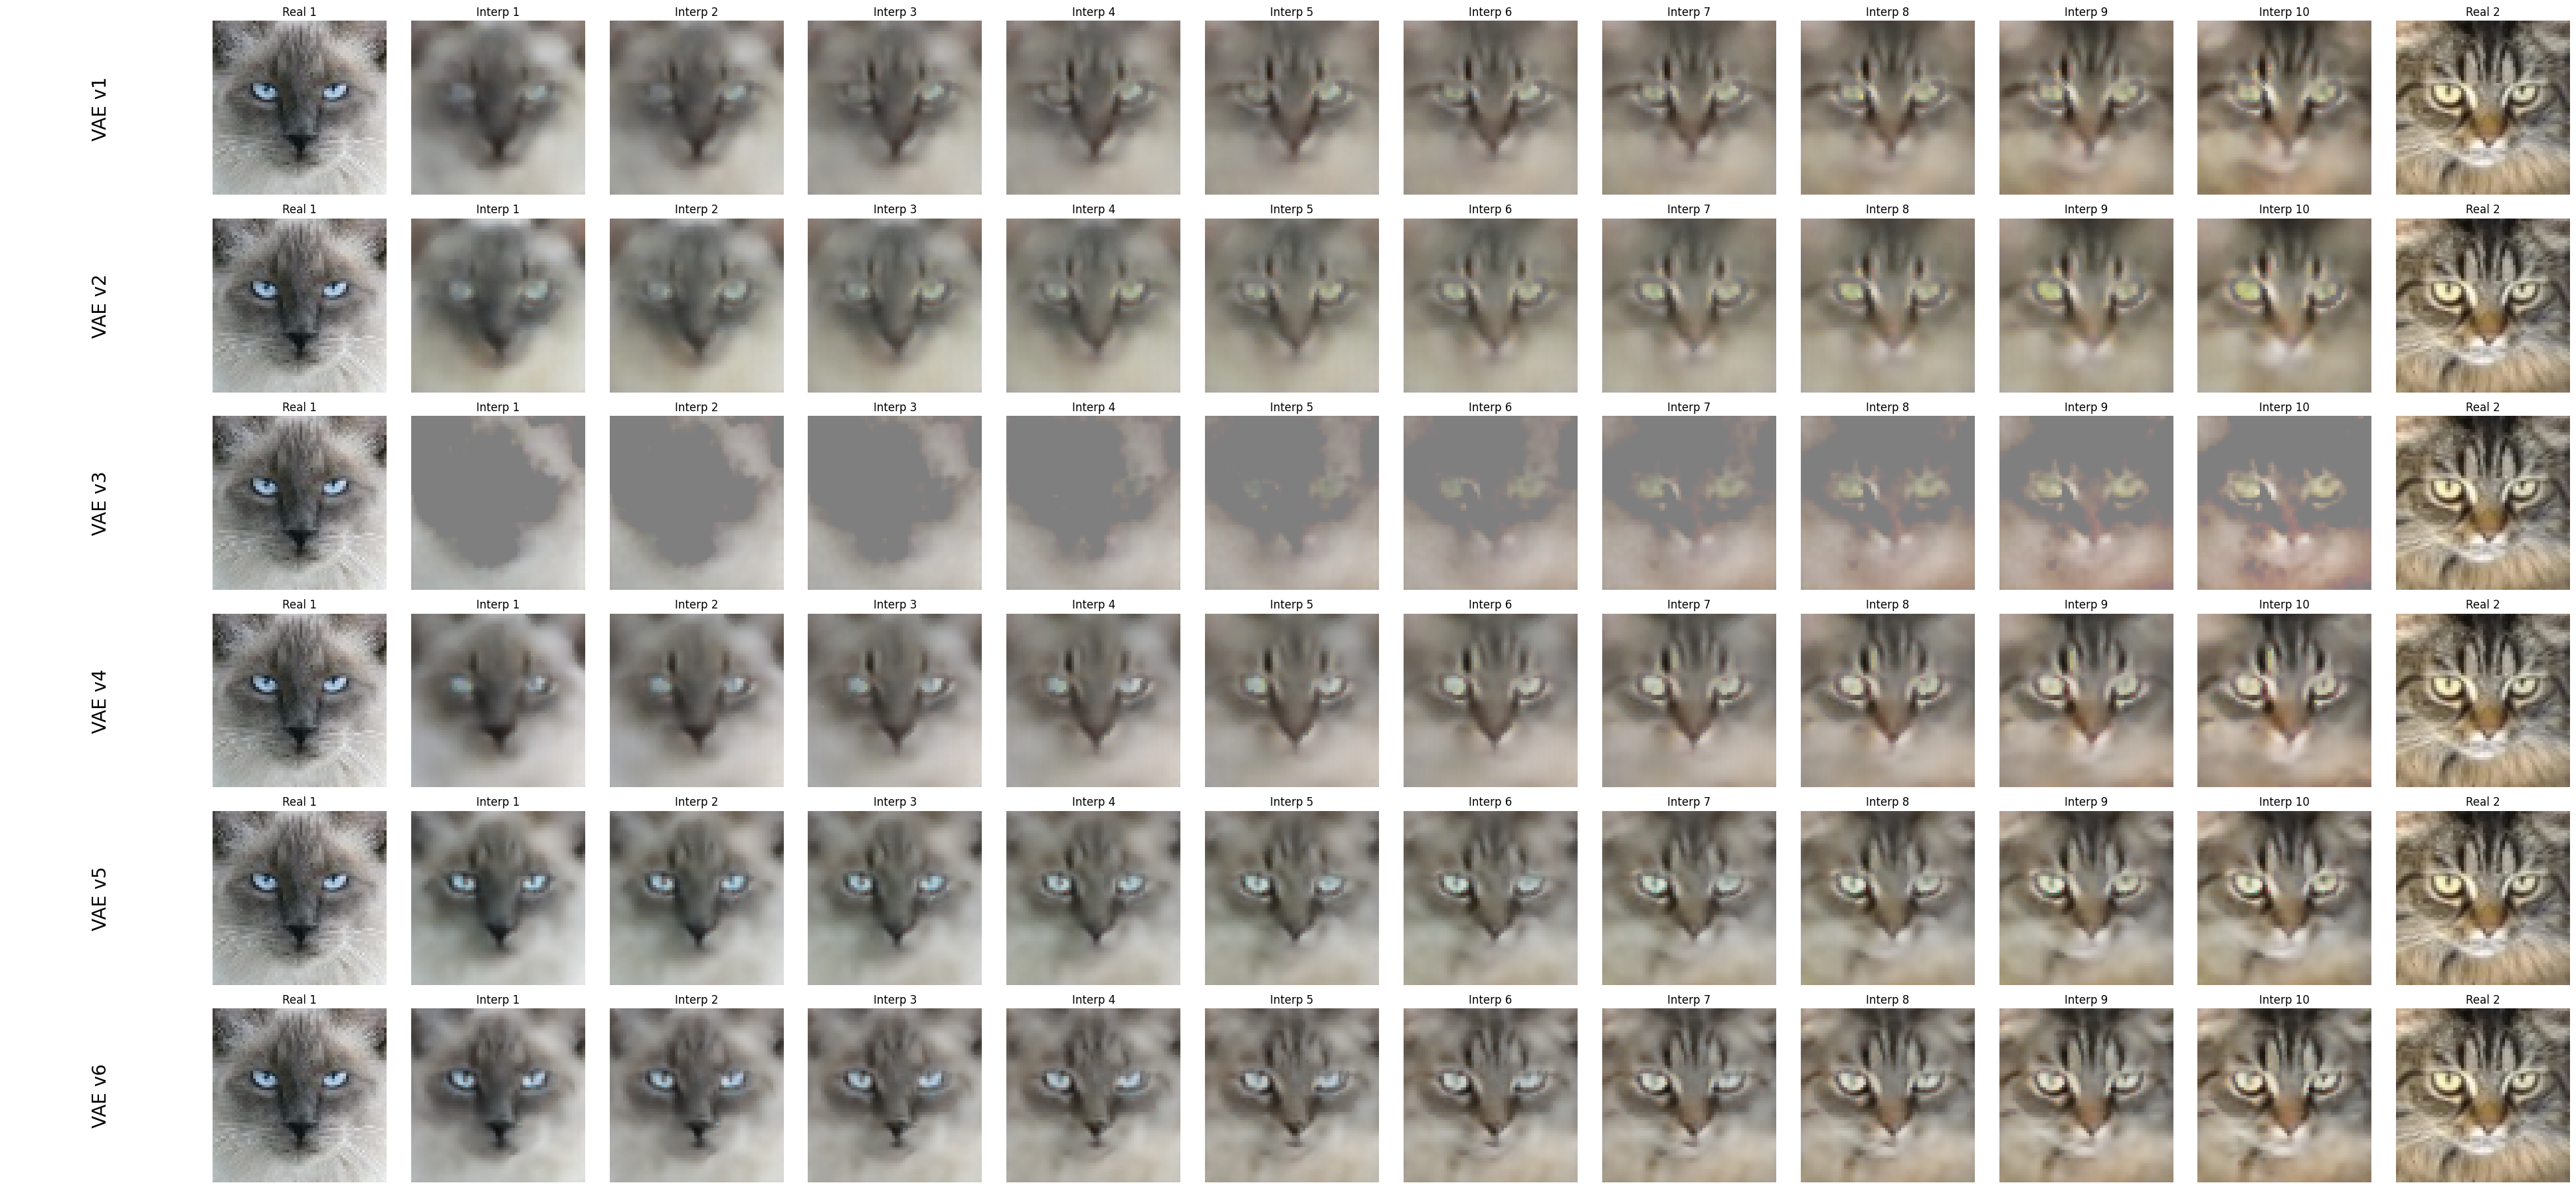

In [84]:
plot_linear_interpolation(
    index_1=6311, index_2=-952,
    models=[
        best_vae_v1, best_vae_v2, best_vae_v3, 
        best_vae_v4, best_vae_v5, best_vae_v6
    ],
    model_names=[
        "VAE v1", "VAE v2", "VAE v3", 
        "VAE v4", "VAE v5", "VAE v6"
    ],
    device="cpu",
    dataset=cat_dataset,
)

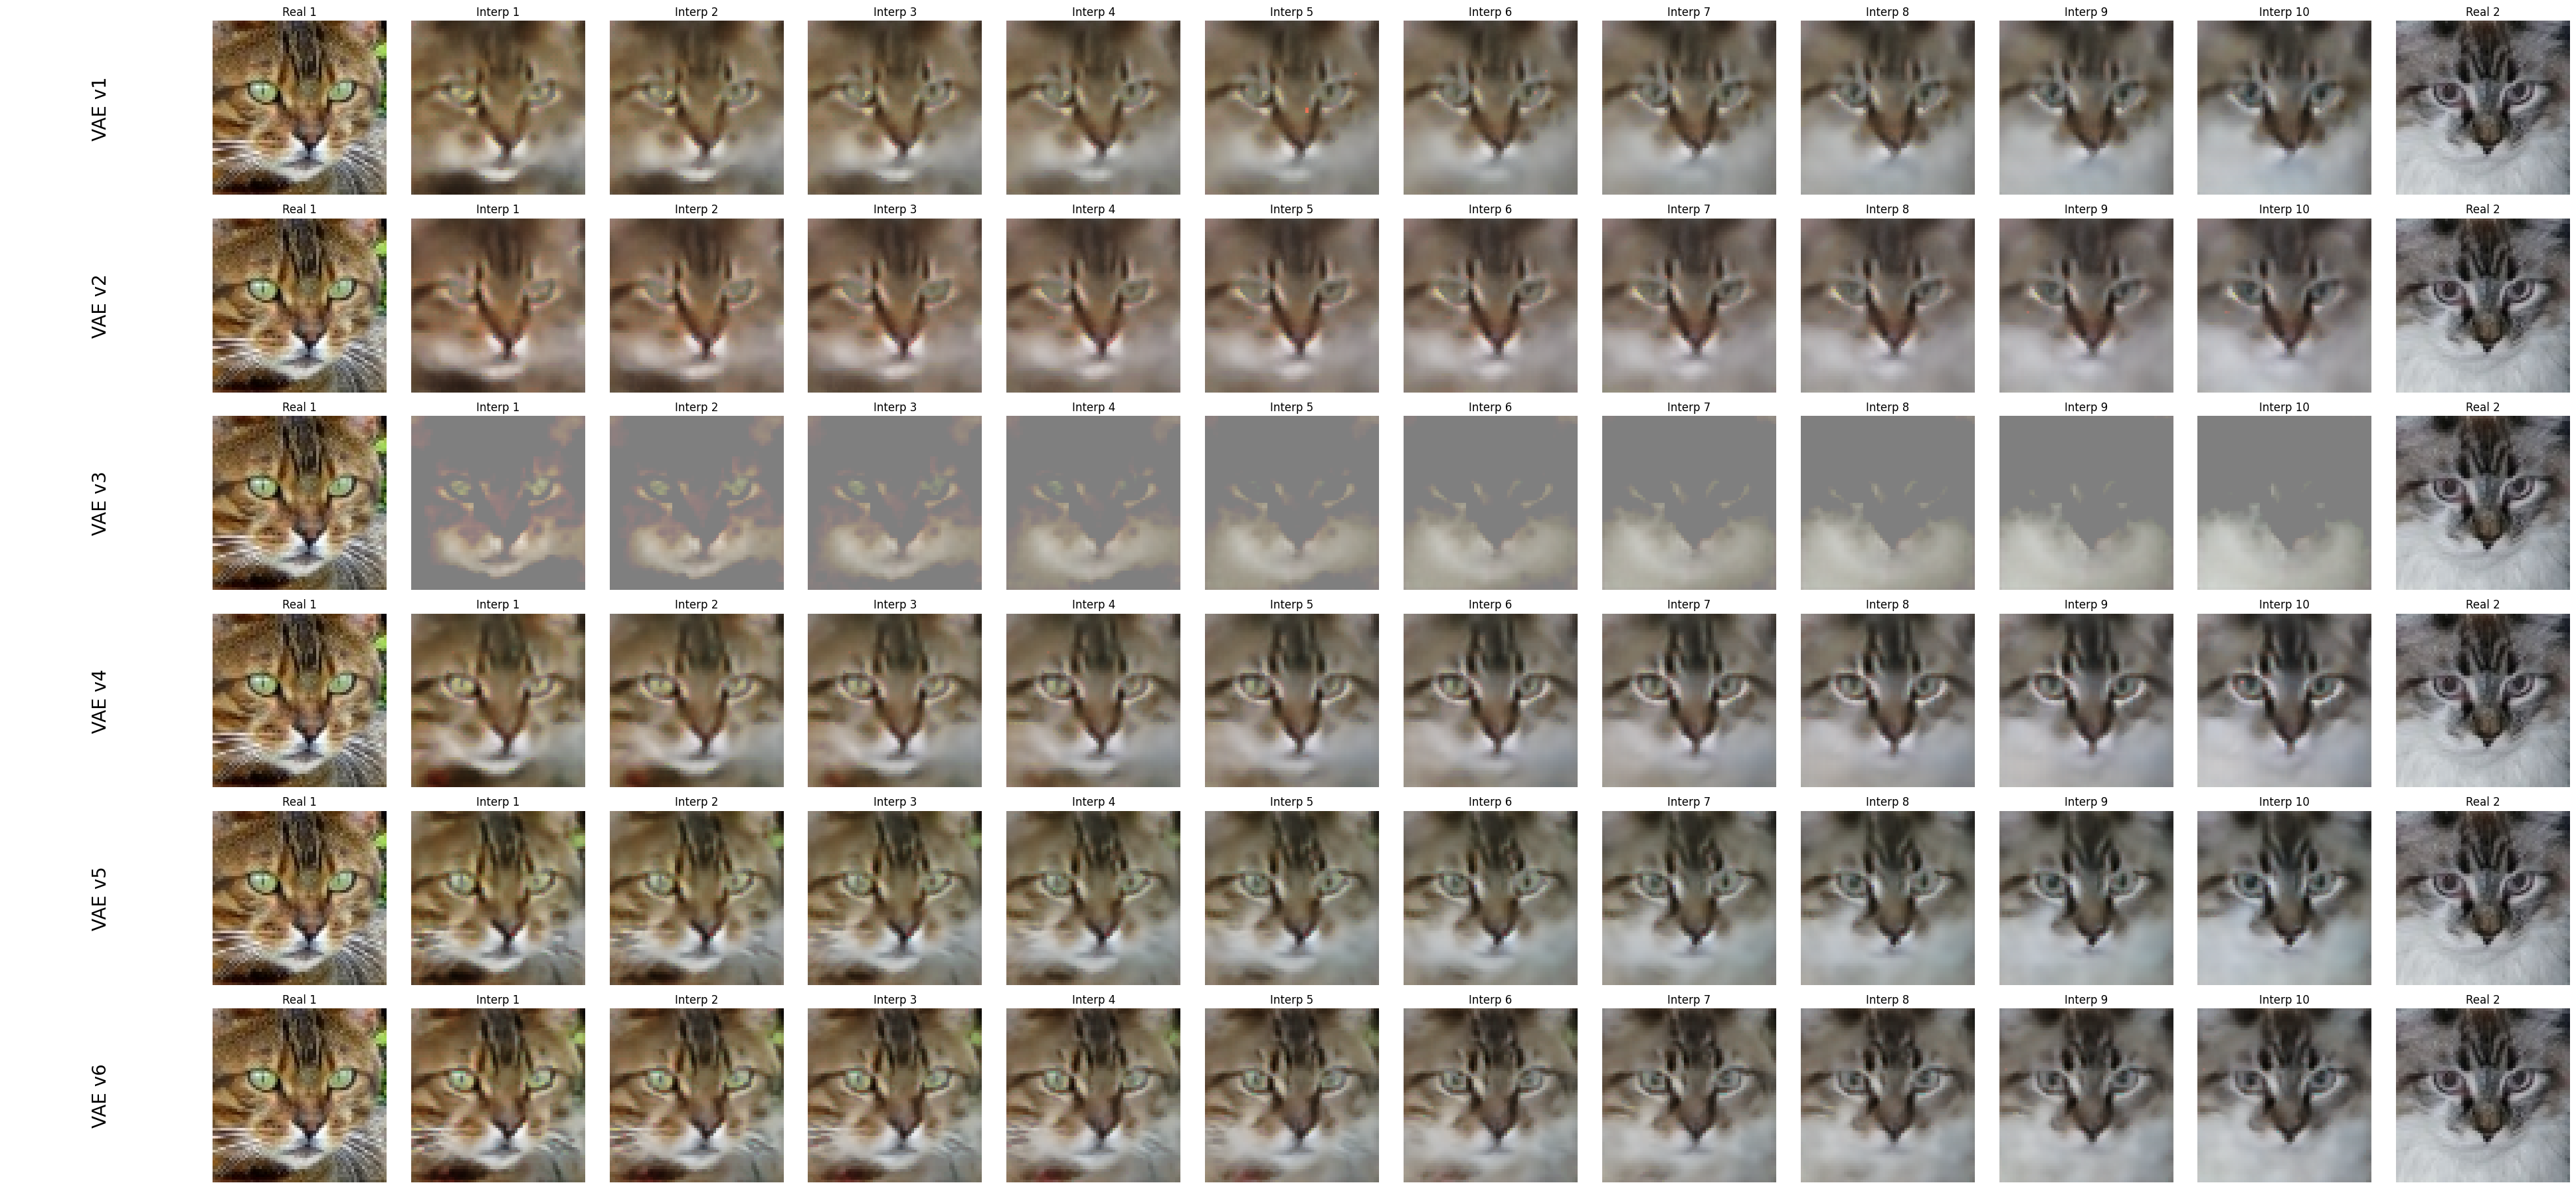

In [168]:
plot_linear_interpolation(
    index_1=-28, index_2=11124,
    models=[
        best_vae_v1, best_vae_v2, best_vae_v3, 
        best_vae_v4, best_vae_v5, best_vae_v6
    ],
    model_names=[
        "VAE v1", "VAE v2", "VAE v3", 
        "VAE v4", "VAE v5", "VAE v6"
    ],
    device="cpu",
    dataset=cat_dataset,
)

## Análisis del espacio latente

In [86]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from sklearn.manifold import TSNE
from typing import Optional

def plot_latent_space_tsne(
    model: VAE,
    dataset: Dataset,
    device: str = "cpu",
    num_samples: Optional[int] = None,
    color_labels: bool = True,
    perplexity: int = 30,
    n_iter: int = 1000,
    random_state: int = 42
):
    """
    Visualiza el espacio latente de un conjunto de datos utilizando t-SNE para reducir la dimensionalidad.

    Args:
        model (VAE): Modelo VAE utilizado para codificar los datos.
        dataset (Dataset): Dataset que contiene las imágenes y opcionalmente las etiquetas.
        device (str, optional): Dispositivo para realizar las operaciones (e.g., 'cpu' o 'cuda'). Por defecto, 'cpu'.
        num_samples (int, optional): Número de muestras del dataset para usar. Si es None, usa todo el dataset.
        color_labels (bool, optional): Si True, colorea los puntos según las etiquetas del dataset, si están disponibles.
        perplexity (int, optional): Parámetro de t-SNE que controla la cantidad de vecinos considerados. Por defecto, 30.
        n_iter (int, optional): Número de iteraciones para optimizar t-SNE. Por defecto, 1000.
        random_state (int, optional): Semilla para reproducibilidad. Por defecto, 42.
    """
    # Limitar el número de muestras si se especifica
    if num_samples is None or num_samples > len(dataset):
        num_samples = len(dataset)

    # Preparar el modelo
    model = model.to(device)
    model.eval()

    latents = []
    labels = []

    # Codificar las imágenes en el espacio latente
    with torch.no_grad():
        for i in range(num_samples):
            img, label = dataset[i]
            img = img.unsqueeze(0).to(device)  # Añadir dimensión batch
            latent, _, _ = model.encode(img)  # Codificar al espacio latente
            latents.append(latent.squeeze().cpu().numpy())
            labels.append(label)

    latents = torch.tensor(latents)
    labels = torch.tensor(labels)

    # Aplicar t-SNE para reducir la dimensionalidad
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=random_state)
    latent_2d = tsne.fit_transform(latents.numpy())

    # Crear el gráfico
    plt.figure(figsize=(10, 8))
    if color_labels:
        scatter = plt.scatter(
            latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="tab10", alpha=0.7, s=30
        )
        plt.colorbar(scatter, label="Labels")
    else:
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7, s=30)

    plt.title("Latent Space Visualization (t-SNE)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(alpha=0.3)
    plt.show()


### VAE v1

c:\Users\tinte\Root\Repositories\Other\animal_face_generation\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


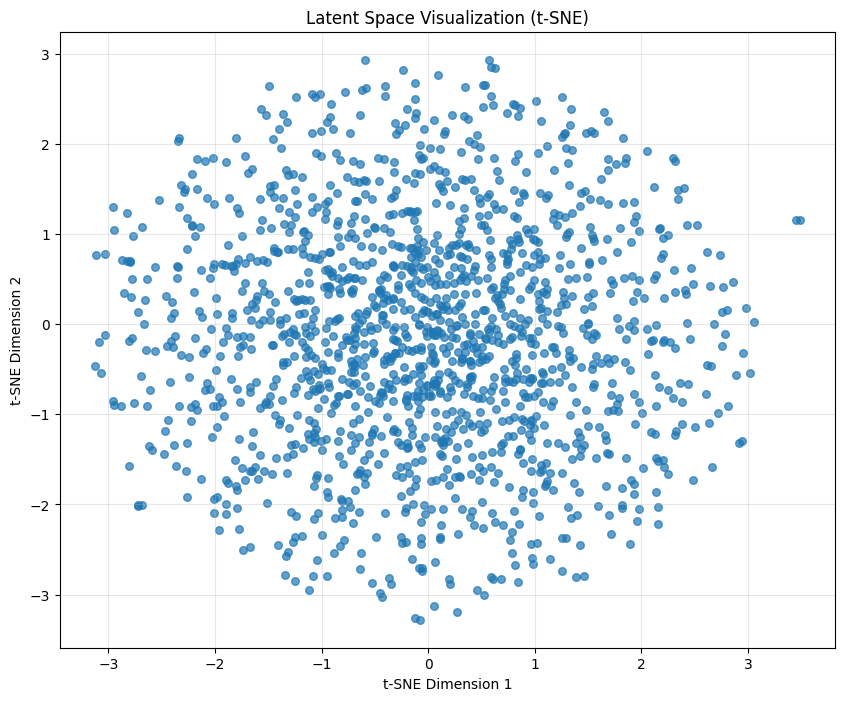

In [ ]:
plot_latent_space_tsne(
    model=best_vae_v1,
    dataset=cat_dataset,
    device="cpu",
    num_samples=1500,
    color_labels=False,
    perplexity=40,
    n_iter=1000
)


### VAE v2

c:\Users\tinte\Root\Repositories\Other\animal_face_generation\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


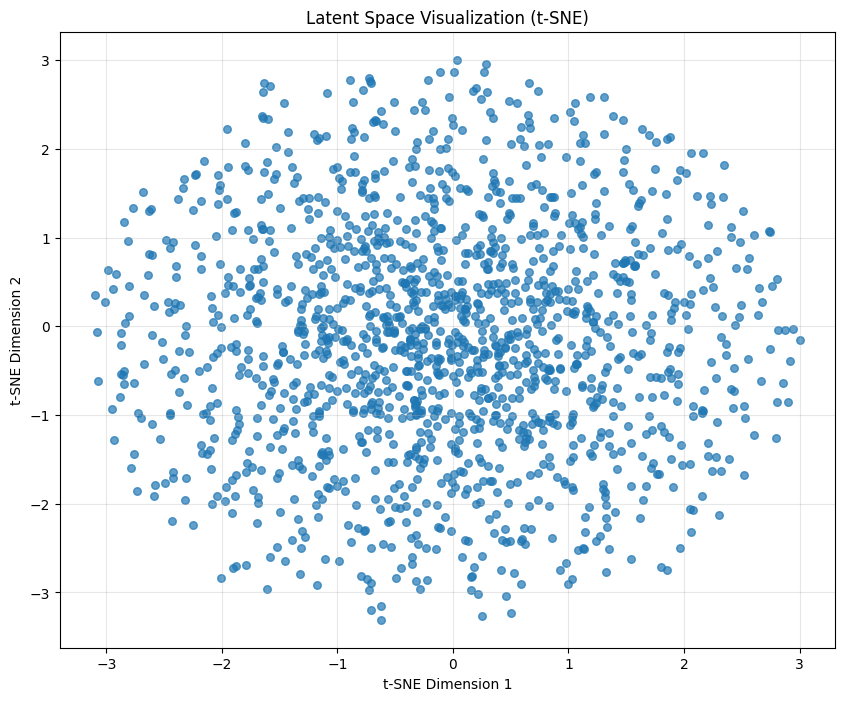

In [ ]:
plot_latent_space_tsne(
    model=best_vae_v2,
    dataset=cat_dataset,
    device="cpu",
    num_samples=1500,
    color_labels=False,
    perplexity=40,
    n_iter=1000
)


### VAE v3

c:\Users\tinte\Root\Repositories\Other\animal_face_generation\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


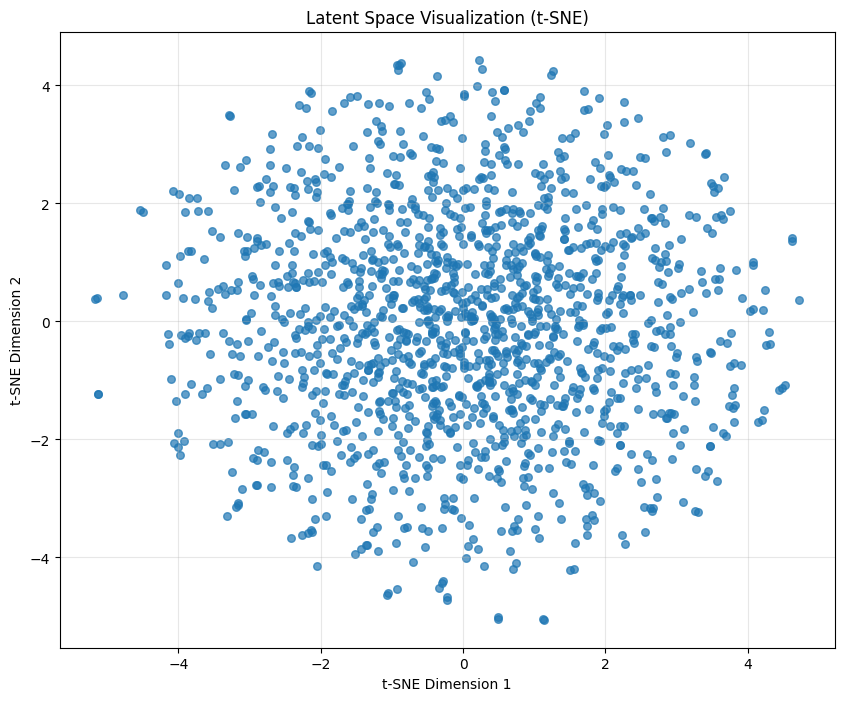

In [ ]:
plot_latent_space_tsne(
    model=best_vae_v3,
    dataset=cat_dataset,
    device="cpu",
    num_samples=1500,
    color_labels=False,
    perplexity=40,
    n_iter=1000
)


### VAE v4

<ipython-input-48-e5ae3978b541>:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  latents = torch.tensor(latents)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


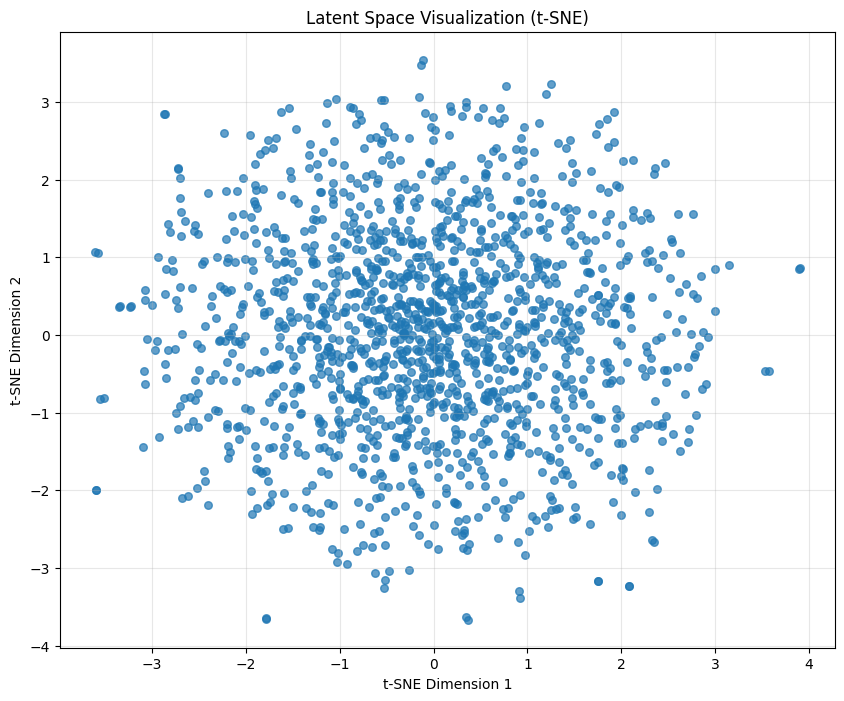

In [ ]:
plot_latent_space_tsne(
    model=best_vae_v4,
    dataset=cat_dataset,
    device="cpu",
    num_samples=1500,
    color_labels=False,
    perplexity=40,
    n_iter=1000
)

### VAE v5

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


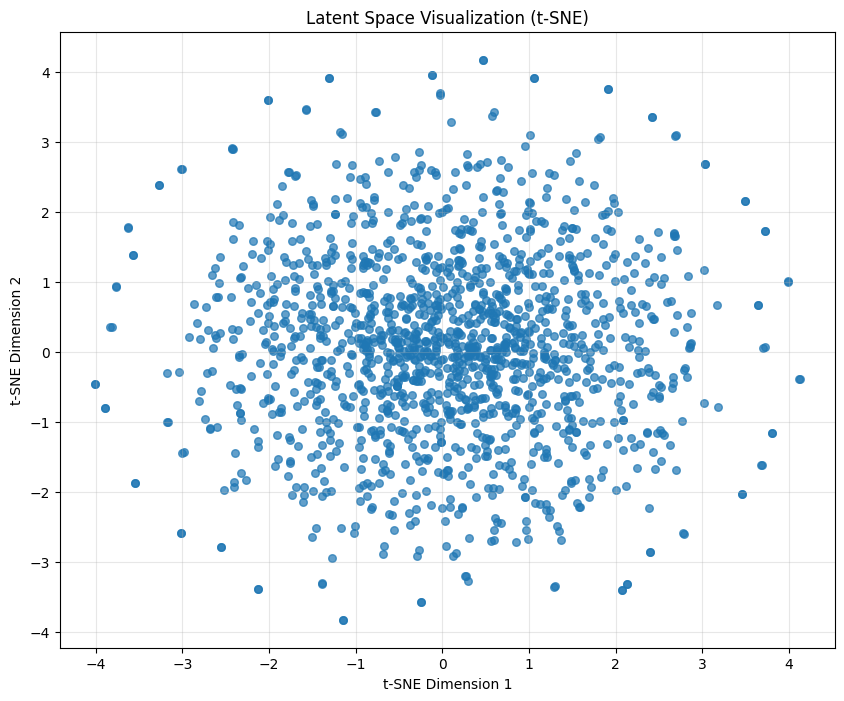

In [ ]:
plot_latent_space_tsne(
    model=best_vae_v5,
    dataset=cat_dataset,
    device="cpu",
    num_samples=1500,
    color_labels=False,
    perplexity=40,
    n_iter=1000
)


### VAE v6

c:\Users\tinte\Root\Repositories\Other\animal_face_generation\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


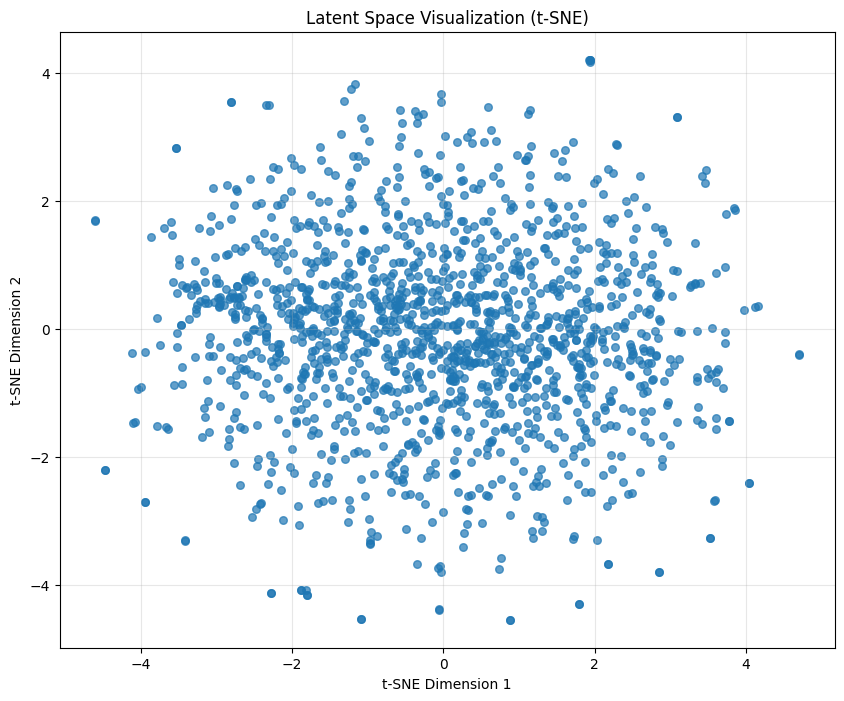

In [169]:
plot_latent_space_tsne(
    model=best_vae_v6,
    dataset=cat_dataset,
    device="cpu",
    num_samples=1500,
    color_labels=False,
    perplexity=40,
    n_iter=1000
)

## Conclusión


Los modelos **v1**, **v2**, **v4**, **v5** y **v6** comparten la misma arquitectura, con la única diferencia en la función de pérdida **BetaLoss**. En el modelo **v1**, se utiliza la función de pérdida estándar de las VAE con un valor de $\beta = 1$. En el modelo **v2**, el valor de $\beta$ se incrementa al doble, es decir, $\beta = 2$. Por otro lado, en los modelos **v4**, **v5** y **v6**, el valor de $\beta$ se reduce progresivamente a $\beta = 0.5$, $\beta = 0.05$ y $\beta = 0.005$ respectivamente.

A partir de los experimentos realizados, se observó que un aumento en el valor de $\beta$, lo que implica una mayor regularización del espacio latente, tiene un impacto negativo en la capacidad de reconstrucción, lo que llevó a **descartar los modelos v1 y v2**. En cambio, al reducir el valor de $\beta$ (es decir, $\beta < 1$), la capacidad de reconstrucción mejora significativamente, sin comprometer de manera importante las interpolaciones. Por este motivo, el modelo **v6** ($\beta = 0.005$) se seleccionó como el mejor, ya que ofrece la **mejor calidad de reconstrucción** sin perder la regularización del espacio latente.

En cuanto al modelo **v3**, aunque presenta una arquitectura más simple con menos parámetros, esta simplicidad impide que el modelo capture adecuadamente la complejidad de las imágenes de rostros de gatos, lo que lo hace **poco viable** para su uso en este contexto.
